In [1]:
import os
def return_package_path():
    cwd = os.getcwd()
    idx = cwd.find("goalscorers-project") + len("goalscorers-project") + 1
    return cwd[:idx] + "goalscorers-private/"
package_paths = [return_package_path()]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
# import pymc as pm
# print(f"Running on PyMC v{pm.__version__}")
# import arviz as az
# print(f"Running on Az v{az.__version__}")
# import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

In [2]:
SCALE_BY_MATCH_EXPECTANCY = False
FINSHING_SKILL = True
SAMPLE_NPXG_DISTRIBUTION = False

In [3]:
season = "2020-2021"
comp_ids = [9, 11, 12, 20]

In [4]:
NUM_CHAINS = 4

# Data

In [5]:
def load_match_expectancies_df(seasons_leagues: list[c.SeasonLeague]) -> pd.DataFrame:
    df_exp = pd.concat(
        [
            pd.read_csv(
                c.FilePath.FOOTBALL_DATA_EDITED
                + f"{season_league.season.season_str}-league-{season_league.league.league_id}-historic-odds.csv"
            )
            for season_league in seasons_leagues
        ],
        ignore_index=True,
    )
    df_exp = df_exp.assign(
        datetime=lambda x: pd.to_datetime(x.datetime),
        date=lambda x: x.datetime.dt.date,
        time=lambda x: x.datetime.dt.time,
    ).drop(columns=["datetime"])
    return df_exp

In [6]:
seasons_leagues = dc.get_seasons_leagues_from_str([season], comp_ids)

In [7]:
df_exp = load_match_expectancies_df(seasons_leagues)

In [8]:
df_test_npxg = pd.read_pickle(
    c.return_goalscorer_project_path() + r"goalscorers-data-files\attempts\attempt-1\model-train-test\npxg\cache\df_test.pickle"
)
df_test_npg = pd.read_pickle(
    c.return_goalscorer_project_path() + r"goalscorers-data-files\attempts\attempt-1\model-train-test\npg\cache\df_test.pickle"
)

In [9]:
merge_on_columns = ["datetime", "home_team", "away_team", "player_id", "player"]

df_test = df_test_npxg.merge(
    df_test_npg[merge_on_columns + [f"F_{c}" for c in range(NUM_CHAINS)] + ["pred_F"]],
    how="left",
    on=merge_on_columns,
    validate="1:1"
)

df_test = dc.add_expectancies(df_test, df_exp)

In [10]:
df = df_test[
    [
        "player_id", "player", "position", "squad", "start", "season", "home", "opposition_team", "frac_90", "home_team", "away_team", "datetime",
        "t", "age", "league", "npxg", "npg", "minutes", "goals", "xg"
    ] + [
            f"pred_npxg_{c}" for c in range(NUM_CHAINS)
    ] + [
        f"F_{c}" for c in range(NUM_CHAINS)
        ] + [
            "pred_npxg", "pred_F", "team_exp", "opp_team_exp"
        ]
]

# Eval

In [11]:
def cap_pred_npg(df: pd.DataFrame, max_npg=2.4, cap_number=0.6) -> pd.DataFrame:
    df.pred_npg_all = df.pred_npg_all.apply(lambda arr: np.where(arr < max_npg, arr, cap_number))
    # df.pred_npg_all = df.pred_npg_all.apply(lambda arr: np.where(arr < 0.07, 0.0, arr))
    return df

In [12]:
def probs(lambda_array: list[float], goals=[0, 1, 2, 3, 4, 5]) -> list[float]:  # length = len(goals)
    if SAMPLE_NPXG_DISTRIBUTION:
        return [scipy.stats.poisson.pmf(goal, mu=lambda_array).mean() for goal in goals]
    else:
        return [scipy.stats.poisson.pmf(goal, mu=lambda_array.mean()) for goal in goals]

In [13]:
def calc_goal_probs(df: pd.DataFrame, pred_col_name="pred_npg_all") -> pd.DataFrame:
    goals = np.sort(df.npg.unique())
    df["probs"] = df[pred_col_name].apply(lambda x: probs(x, goals))

    df_probs = pd.DataFrame(df.probs.tolist(), columns=[f"prob_npg_{goal}" for goal in goals])

    return df_probs

In [14]:
def add_ll_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df["log_likelihood"] = np.log(scipy.stats.poisson.pmf(df.npg, mu=df["pred_npg"]))
    return df

In [15]:
def create_predicted_npg_distribution(df: pd.DataFrame) -> pd.DataFrame:

    for c in range(NUM_CHAINS):
        if not FINSHING_SKILL:
            df[f"F_{c}"] = 0.0
        df[f"pred_npg_{c}"] = df[f"pred_npxg_{c}"] * df[f"F_{c}"].apply(lambda x: np.exp(x))

    df["pred_npg_all"] = df.apply(lambda x: np.concatenate((x.pred_npg_0, x.pred_npg_1)), axis=1)
    for c in range(2, NUM_CHAINS):
        df.pred_npg_all = df.apply(lambda x: np.concatenate((x.pred_npg_all, x[f"pred_npg_{c}"])), axis=1)
    
    return df

In [16]:
def calc_goal_outcomes(df: pd.DataFrame, goals=[0, 1, 2, 3, 4, 5]) -> pd.DataFrame:
    goals = np.sort(df.npg.unique())
    df_npgs = pd.get_dummies(df.npg)
    for goal in goals:
        if goal not in df_npgs.columns:
            df_npgs[goal] = False
    df_npgs = df_npgs[goals]

    return df_npgs

In [17]:
def add_match_expectancy_correction(df: pd.DataFrame) -> pd.DataFrame:
    df_matches = (
        df
        .query("start")
        .groupby(["home_team", "away_team", "datetime", "home"], as_index=False)
        .agg(
            pred_npg_total=("pred_npg90", sum),
            team_exp=("team_exp", "first"),
        )
        .sort_values(["datetime", "home"], ignore_index=True)
        .assign(
            match_exp_npg_total=lambda x: x.team_exp * (1.0 - 0.092),
            correction=lambda x: (x.match_exp_npg_total / x.pred_npg_total)
        )
    )
    return (
        df
        .merge(
            df_matches[["home_team", "away_team", "datetime", "home", "correction"]], 
            how="left", 
            on=["home_team", "away_team", "datetime", "home"],
            validate="m:1"
        )
    )

In [18]:
def calc_df_player_abs_diff(df: pd.DataFrame):
    return (
        df
        .groupby("player_id", as_index=False)
        .agg(
            player=("player", "first"),
            mean_pred_npg=("pred_npg", "mean"),
            mean_npg=("npg", "mean"),
            n_matches=("player_id", "count")
        )
        .assign(
            abs_diff_npg=lambda x: abs(x.mean_pred_npg - x.mean_npg.mean()),
            error=lambda x: x.abs_diff_npg * x.n_matches / x.n_matches.sum()
        )
    )

In [19]:
# df_eval = df.copy()
# df_eval = create_predicted_npg_distribution(df_eval)
# df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
# df_eval = cap_pred_npg(df_eval, max_npg=1.4)
# df_eval["pred_npg90"] = df_eval.pred_npg / df_eval.frac_90
# df_eval = add_match_expectancy_correction(df_eval)
# df_eval["pred_npg_all"] = df_eval.pred_npg_all * df_eval.correction
# df_eval = cap_pred_npg(df_eval)
# df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
# df_probs = calc_goal_probs(df_eval)
# df_npgs = calc_goal_outcomes(df_eval)
# df_eval = df_eval.join(df_probs)
# df_eval

In [20]:
df_eval = df.copy()
df_eval = create_predicted_npg_distribution(df_eval)
df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
df_eval = cap_pred_npg(df_eval, max_npg=1.4)
df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
if SCALE_BY_MATCH_EXPECTANCY:
    df_eval["pred_npg90"] = df_eval.pred_npg / df_eval.frac_90
    df_eval = add_match_expectancy_correction(df_eval)
    df_eval["pred_npg_all"] = df_eval.pred_npg_all * df_eval.correction
    df_eval = cap_pred_npg(df_eval)
    df_eval["pred_npg"] = df_eval.pred_npg_all.apply(lambda x: x.mean())
    
df_eval["pred_npg90"] = df_eval.pred_npg / df_eval.frac_90
df_eval["pred_npg70"] = df_eval.pred_npg * 70.0 / df_eval.minutes
    
df_probs = calc_goal_probs(df_eval)
df_npgs = calc_goal_outcomes(df_eval)
df_eval = df_eval.join(df_probs)

df_eval["likelihood"] = pd.DataFrame(df_npgs.values * df_probs.values).sum(axis=1)
df_eval["log_likelihood"] = np.log(df_eval.likelihood)
df_eval["mse"] = (df_eval.pred_npg - df_eval.npg) ** 2

In [54]:
# df_eval[["player_id", "datetime", "home_team", "away_team", "pred_npg"]].to_csv(r"C:\Users\benja\Downloads\ben_model_predictions.csv", index=False)

### Performance

In [21]:
minutes_threshold = 0
df_test_set = df_eval.query("start & minutes >= @minutes_threshold").reset_index(drop=True)

In [22]:
target_edge = 0.02
df_test_set = df_test_set.assign(
    anytime_npg_model_prob=lambda x: (1.0 - x.prob_npg_0),
    anytime_npg_outcome=lambda x: (x.npg > 0) * 1,
    model_odds=lambda x: 1.0 / x.anytime_npg_model_prob,
    hypothetical_back_bet_odds=lambda x: (1.0 + target_edge) * x.model_odds,
    hypothetical_lay_bet_odds=lambda x: (1.0 - target_edge) * x.model_odds,
    hypothetical_back_profit=lambda x: x.hypothetical_back_bet_odds * (x.npg > 0) - (x.npg == 0),
    hypothetical_lay_profit=lambda x: -x.hypothetical_lay_bet_odds * (x.npg > 0) + (x.npg == 0),
)

In [23]:
print(f"Number of predictions = {len(df_test_set): ,}")
print("Leagues: ", *df_test_set.league.unique())
print("Dates (inclusive): ", df_test_set.datetime.min(), " to ", df_test_set.datetime.max(), "\n")

print(f"Log likelihood = {df_test_set['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_test_set['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_test_set.log_likelihood.mean()): .3f}")
print(f"Average model prob = {df_test_set.anytime_npg_model_prob.mean(): .3f}")
print(f"Average outcome = {df_test_set.anytime_npg_outcome.mean(): .3f}")
print(f"Hypothetical back profit = £{df_test_set.query('model_odds < 100').hypothetical_back_profit.sum(): ,.2f}")
print(f"Hypothetical lay profit = £{df_test_set.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical profit = £{df_test_set.query('model_odds < 100').hypothetical_back_profit.sum() + df_test_set.hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical ROI = {100 * (df_test_set.query('model_odds < 100').hypothetical_back_profit.sum() + df_test_set.query('model_odds < 100').hypothetical_lay_profit.sum())/ (len(df_test_set.query('model_odds < 100')) * 2): .2f}%")

Number of predictions =  28,078
Leagues:  12 9 11 20
Dates (inclusive):  2020-09-20 16:30:00  to  2021-05-23 19:00:00 

Log likelihood = -8,108.87
MSE =  0.10127
Average likelihood =  0.749
Average model prob =  0.097
Average outcome =  0.095
Hypothetical back profit = £-1,315.44
Hypothetical lay profit = £ 2,180.68
Hypothetical profit = £ 2,192.35
Hypothetical ROI =  1.66%


In [24]:
position = "FW"
df_position = df_test_set.query("position == @position").reset_index(drop=True)
print(f"Number of predictions = {len(df_position): ,}")
print(f"Log likelihood = {df_position['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_position['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_position.log_likelihood.mean()): .3f}")
print(f"Average model prob = {df_position.anytime_npg_model_prob.mean(): .3f}")
print(f"Average outcome = {df_position.anytime_npg_outcome.mean(): .3f}")
print(f"Hypothetical back profit = £{df_position.query('model_odds < 100').hypothetical_back_profit.sum(): ,.2f}")
print(f"Hypothetical lay profit = £{df_position.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical profit = £{df_position.query('model_odds < 100').hypothetical_back_profit.sum() + df_position.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical ROI = {100 * (df_position.query('model_odds < 100').hypothetical_back_profit.sum() + df_position.query('model_odds < 100').hypothetical_lay_profit.sum())/ (len(df_position.query('model_odds < 100')) * 2): .2f}%")

Number of predictions =  4,059
Log likelihood = -2,582.94
MSE =  0.28091
Average likelihood =  0.529
Average model prob =  0.233
Average outcome =  0.246
Hypothetical back profit = £ 979.85
Hypothetical lay profit = £-821.43
Hypothetical profit = £ 158.43
Hypothetical ROI =  1.95%


In [25]:
df_player_abs_diff = calc_df_player_abs_diff(df_test_set)
df_player_abs_diff.error.sum()

0.07287885586757882

In [26]:
player_id = "92e7e919"
df_player = df_test_set.query("player_id == @player_id").reset_index(drop=True)
print(f"Number of predictions = {len(df_player)}")
print(f"Log likelihood = {df_player['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_player['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_player.log_likelihood.mean()): .3f}")
print(f"Average model prob = {df_player.anytime_npg_model_prob.mean(): .3f}")
print(f"Average outcome = {df_player.anytime_npg_outcome.mean(): .3f}")
print(f"Hypothetical back profit = £{df_player.query('model_odds < 100').hypothetical_back_profit.sum(): ,.2f}")
print(f"Hypothetical lay profit = £{df_player.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical profit = £{df_player.query('model_odds < 100').hypothetical_back_profit.sum() + df_player.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical ROI = {100 * (df_player.query('model_odds < 100').hypothetical_back_profit.sum() + df_player.query('model_odds < 100').hypothetical_lay_profit.sum())/ (len(df_player.query('model_odds < 100')) * 2): .2f}%")

Number of predictions = 34
Log likelihood = -24.33
MSE =  0.27186
Average likelihood =  0.489
Average model prob =  0.281
Average outcome =  0.324
Hypothetical back profit = £ 14.69
Hypothetical lay profit = £-13.21
Hypothetical profit = £ 1.48
Hypothetical ROI =  2.17%


In [27]:
home_team = "Manchester City"
away_team = "Brighton & Hove Albion"
home = 1
df_test_match = df_test_set.query("(home_team == @home_team) & (away_team == @away_team) & (home == @home)").reset_index(drop=True)
print(f"Number of predictions = {len(df_test_match)}")
print(f"Log likelihood = {df_test_match['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_test_match['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_test_match.log_likelihood.mean()): .3f}")
print(f"Average model prob = {df_test_match.anytime_npg_model_prob.mean(): .3f}")
print(f"Average outcome = {df_test_match.anytime_npg_outcome.mean(): .3f}")
print(f"Hypothetical back profit = £{df_test_match.query('model_odds < 100').hypothetical_back_profit.sum(): ,.2f}")
print(f"Hypothetical lay profit = £{df_test_match.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical profit = £{df_test_match.query('model_odds < 100').hypothetical_back_profit.sum() + df_test_match.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical ROI = {100 * (df_test_match.query('model_odds < 100').hypothetical_back_profit.sum() + df_test_match.query('model_odds < 100').hypothetical_lay_profit.sum())/ (len(df_test_match.query('model_odds < 100')) * 2): .2f}%")

Number of predictions = 10
Log likelihood = -2.62
MSE =  0.06955
Average likelihood =  0.770
Average model prob =  0.134
Average outcome =  0.100
Hypothetical back profit = £-5.34
Hypothetical lay profit = £ 5.49
Hypothetical profit = £ 0.14
Hypothetical ROI =  0.72%


In [28]:
odds_range = (1.0, 3.0)
df_odds_range = df_test_set.query("(@odds_range[0] <= model_odds) & (model_odds < @odds_range[1])").reset_index(drop=True)
print(f"Number of predictions = {len(df_odds_range)}")
print(f"Log likelihood = {df_odds_range['log_likelihood'].sum(): ,.2f}")
print(f"MSE = {df_odds_range['mse'].mean(): .5f}")
print(f"Average likelihood = {np.exp(df_odds_range.log_likelihood.mean()): .3f}")
print(f"Average model prob = {df_odds_range.anytime_npg_model_prob.mean(): .3f}")
print(f"Average outcome = {df_odds_range.anytime_npg_outcome.mean(): .3f}")
print(f"Hypothetical back profit = £{df_odds_range.query('model_odds < 100').hypothetical_back_profit.sum(): ,.2f}")
print(f"Hypothetical lay profit = £{df_odds_range.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical profit = £{df_odds_range.query('model_odds < 100').hypothetical_back_profit.sum() + df_odds_range.query('model_odds < 100').hypothetical_lay_profit.sum(): ,.2f}")
print(f"Hypothetical ROI = {100 * (df_odds_range.query('model_odds < 100').hypothetical_back_profit.sum() + df_odds_range.query('model_odds < 100').hypothetical_lay_profit.sum())/ (len(df_odds_range.query('model_odds < 100')) * 2): .2f}%")

Number of predictions = 653
Log likelihood = -675.72
MSE =  0.58387
Average likelihood =  0.355
Average model prob =  0.364
Average outcome =  0.462
Hypothetical back profit = £ 492.63
Hypothetical lay profit = £-459.55
Hypothetical profit = £ 33.08
Hypothetical ROI =  2.53%


In [29]:
(
    df_test_set[["player", "player_id", "league", "t", "position", "home", "home_team", "away_team", "frac_90", "pred_npg", "npg", "model_odds"]]
    .query("league == 9")
    .head(100)
)

,player,player_id,league,t,position,home,home_team,away_team,frac_90,pred_npg,npg,model_odds
40,Jimmy Dunne,1fdfd6da,9,2,CB,0,Leicester City,Burnley,1.000,0.100,1,10.488
41,Kevin Long,5a4280b1,9,2,CB,0,Leicester City,Burnley,1.000,0.026,0,38.572
42,Josh Brownhill,47369df8,9,2,CM,0,Leicester City,Burnley,1.000,0.076,0,13.653
43,Ashley Westwood,495945ef,9,2,CM,0,Leicester City,Burnley,1.000,0.021,0,48.812
44,Charlie Taylor,cc2d7ad5,9,2,FB,0,Leicester City,Burnley,1.000,0.000,0,"39,679,291,871,105.695"
45,Phil Bardsley,1ae30132,9,2,FB,0,Leicester City,Burnley,1.000,0.034,0,29.929
46,Chris Wood,4e9a0555,9,2,FW,0,Leicester City,Burnley,1.000,0.295,1,3.914
47,Jay Rodriguez,4ab53cdb,9,2,FW,0,Leicester City,Burnley,0.767,0.133,0,8.015
48,Dwight McNeil,fc15fb84,9,2,WM,0,Leicester City,Burnley,1.000,0.039,0,26.473
49,Robbie Brady,96bb8cc2,9,2,WM,0,Leicester City,Burnley,0.433,0.046,0,22.075


In [30]:
df_test_table = df_test_set.copy()#.query("position == 'FW'")

goals = np.sort(df_test_table.npg.unique())

df_npgs_test_table =  calc_goal_outcomes(df_test_table)
df_probs_test_table =  calc_goal_probs(df_test_table)

df_table = (
    pd.DataFrame({"goals": goals, 
                  "obs": df_npgs_test_table.sum().values, 
                  "exp": df_probs_test_table.sum().values})
)

# Cap the chi-squared table s.t. most extreme category has at least 5 obs 
idx = df_table.index.max()
while (df_table.loc[idx, "obs"] < 5):
    df_table.loc[idx - 1, :] += df_table.loc[idx, :]
    df_table = df_table.iloc[: idx]
    idx = df_table.index.max()

df_table = (
    df_table
    .assign(
        goals=lambda x: x.index,
        mean_obs=lambda x: x.obs / x.obs.sum(),
        mean_exp=lambda x: x.exp / x.obs.sum(),
        t_stat=lambda x: (x.obs - x.exp) ** 2 / x.exp
    )
    [["goals", "mean_obs", "mean_exp", "obs", "exp", "t_stat"]]
)
t_stat = df_table.t_stat.sum()
p_val = 1 - scipy.stats.chi2.cdf(t_stat, len(df_table) - 1)
print(f"Chi-Squared test p-value: {p_val: .5f}")
df_table

Chi-Squared test p-value:  0.72370


,goals,mean_obs,mean_exp,obs,exp,t_stat
0,0,0.905,0.903,25414,"25,368.211",0.083
1,1,0.085,0.087,2394,"2,444.818",1.056
2,2,0.009,0.009,244,240.646,0.047
3,3,0.001,0.001,26,24.179,0.137


In [31]:
print(f"Observed Goals = {(df_table.goals * df_table.obs).sum(): ,.0f}")
print(f"Model Goals = {(df_table.goals * df_table.exp).sum(): ,.0f}")

Observed Goals =  2,960
Model Goals =  2,999


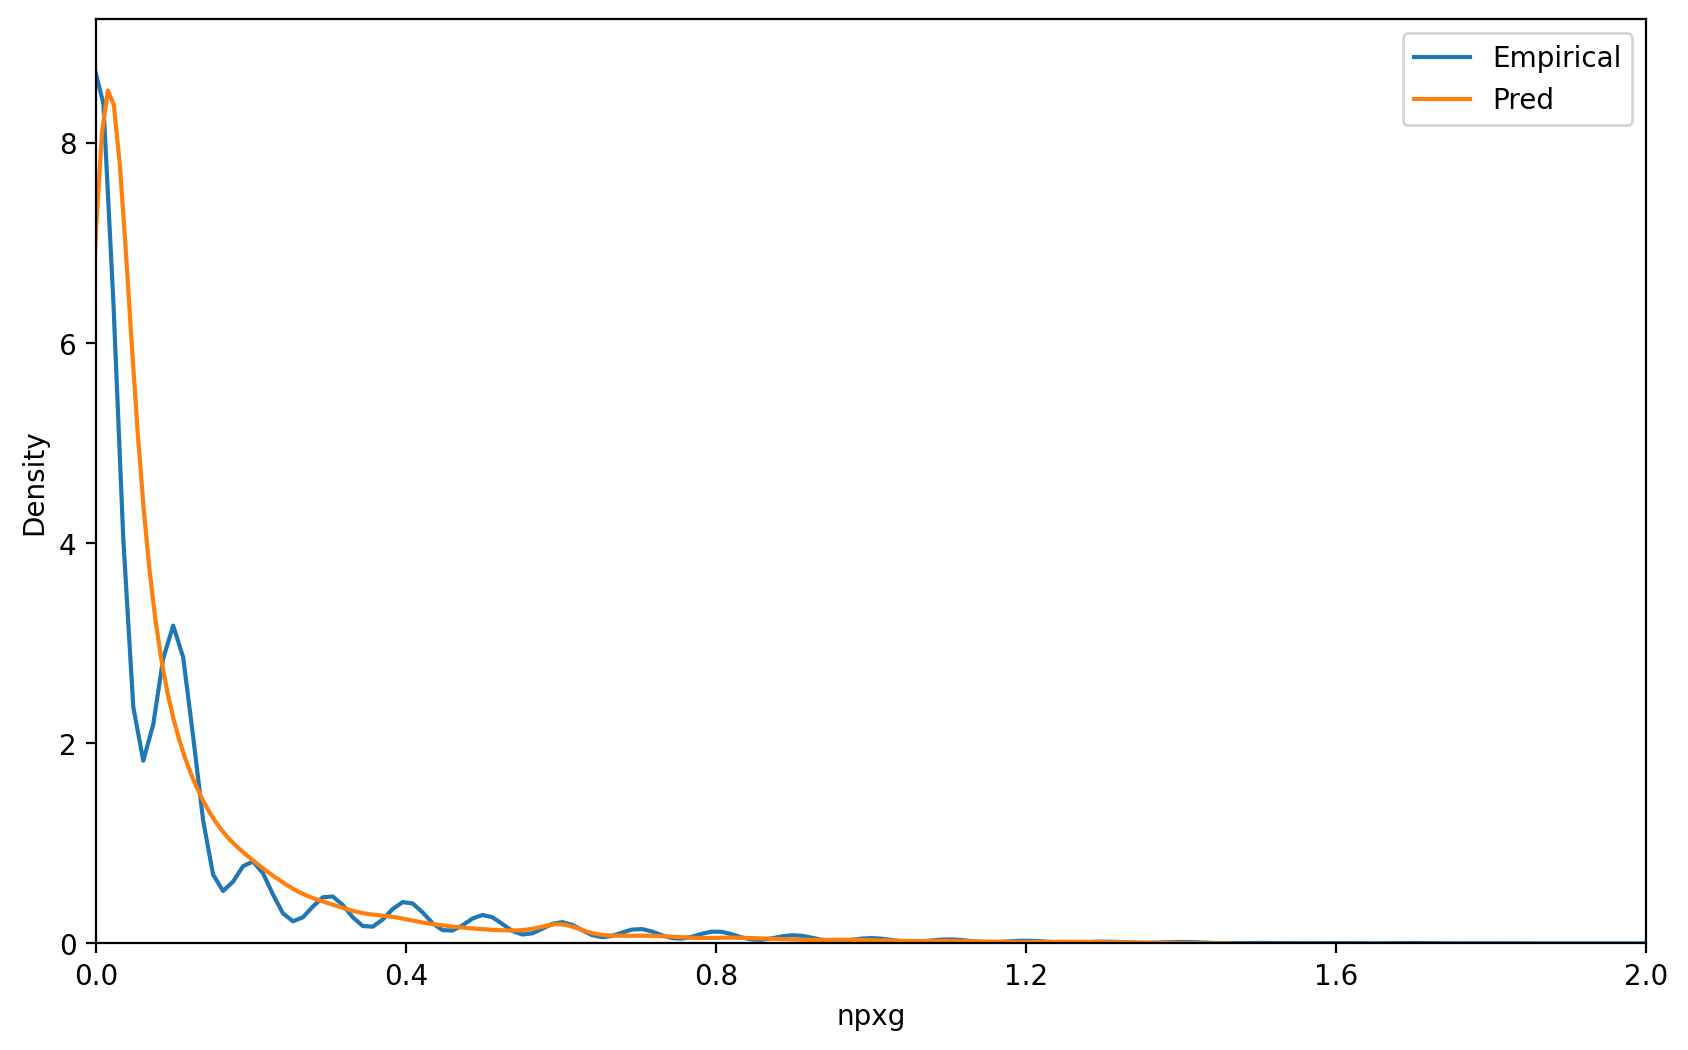

In [32]:
# Expectancies vs observed expectancies

df_test_plot = df_test_set#.query("position == 'WM'")

plt.xticks(np.arange(0, 3.2, 0.4))
plt.xlim(0.0, 2.0)
sns.kdeplot(df_test_plot.npxg)
pred_npg_sample = np.array([])
for player_match in df_test_plot.pred_npg_all.values:
    pred_npg_sample = np.concatenate((pred_npg_sample, np.random.choice(player_match, 1, True)))
sns.kdeplot(pred_npg_sample)
plt.legend(["Empirical", "Pred"])
plt.show()

#### Backtest

In [33]:
df_befair_fbref_map = pd.read_parquet(c.FilePath.BETFAIR_DATA_EDITED + "betfair-exchange-fbref-data-map.parquet")
df_betfair = (
    pd
    .read_parquet(c.FilePath.BETFAIR_DATA_EDITED + "betfair-exchange-data.parquet")
    .query("(market_name == 'Player To Score') | (market_name == 'To Score')")
    .reset_index(drop=True)
    .assign(
        open_date=lambda x:pd.to_datetime(x.open_date).dt.tz_localize(None),
        publish_time=lambda x:pd.to_datetime(x.publish_time),
        mins_before_ko=lambda x: (x.open_date - x.publish_time).dt.total_seconds() / 60.0
    )
)

In [34]:
print(f"Number of model predictions = {len(df_test_set): ,}")
df_backtest = df_test_set.merge(df_befair_fbref_map, how="inner", on=["home_team", "away_team", "datetime", "player_id"])
print(f"Number of model predictions with betfair odds = {len(df_backtest): ,}")
df_backtest = df_backtest.merge(df_betfair, how="inner", on=["event_id", "runner_id"])
print(f"Number of betfair odds = {len(df_backtest): ,}")

Number of model predictions =  28,078
Number of model predictions with betfair odds =  12,004
Number of betfair odds =  94,003


In [35]:
position = "FW"

# Define a function to find the closest value in a group
def find_closest_value(group):
    return group.loc[(group['ltp'] - group['model_odds']).abs().idxmin(), 'ltp']

df_backtest = (
    df_backtest
    .query("start")
    # .query("position == @position")
    # .query("frac_90 > 0.9")
    .query("(0.0 < mins_before_ko) & (mins_before_ko < 60.0)")
    .sort_values("publish_time", ignore_index=True)
    .groupby(
        ["player_id", "player",	"runner_name", "position",	"squad", "start", "home", "opposition_team", "frac_90", "home_team", "away_team",
         "datetime", "league", "xg", "prob_npg_0", "anytime_npg_model_prob", "pred_npg90", "pred_npg70", "hypothetical_back_bet_odds",
         "hypothetical_lay_bet_odds", "event_id", "runner_id", "goals", "pred_npg", "model_odds", ],
        as_index=False
    )
    .agg(
        ltp=("ltp", "last")
        # ltp=("ltp", mode)
    )
    # .apply(find_closest_value)
    # .reset_index(name='ltp')

)

In [36]:
df_backtest = (
    df_backtest
    .assign(
        anytime_npg90_prob=lambda x: 1.0 - np.exp(-x.pred_npg90),
        anytime_npg70_prob=lambda x: 1.0 - np.exp(-x.pred_npg70),
        hypothetical_back_bet_odds=lambda x: 1.0 / x.anytime_npg70_prob,
        hypothetical_lay_bet_odds=lambda x: 1.0 / x.anytime_npg90_prob,
        
        hypothetical_lay_bet_back_odds=lambda x: 1.0 / (x.hypothetical_lay_bet_odds - 1.0) + 1.0,
        lay_ltp=lambda x: 1.0 / (x.ltp - 1.0) + 1.0,
        back_profit=lambda x: (x.ltp - 1.0) * (x.goals > 0) - (x.goals == 0),
        lay_profit=lambda x: (x.lay_ltp - 1.0) * (x.goals == 0) - (x.goals > 0),
        back_edge=lambda x: (x.ltp - 1.0) / x.hypothetical_back_bet_odds - (1.0 - (1.0 / x.hypothetical_back_bet_odds)),
        lay_edge=lambda x: (x.lay_ltp - 1.0) / x.hypothetical_lay_bet_back_odds - (1.0 - (1.0 / x.hypothetical_lay_bet_back_odds)),
        edge=lambda x: np.maximum(x.back_edge, x.lay_edge),
        back_bet=lambda x: x.ltp > x.hypothetical_back_bet_odds,
        lay_bet=lambda x: x.lay_ltp > x.hypothetical_lay_bet_back_odds,
        bet=lambda x: x.lay_bet | x.back_bet,
        bet_back_profit=lambda x: x.back_bet * x.back_profit,
        bet_lay_profit=lambda x: x.lay_bet * x.lay_profit,
        anytime_g_betfair_prob=lambda x: 1.0 / x.ltp,
        betfair_xg=lambda x: -np.log(1.0 - x.anytime_g_betfair_prob),
        betfair_likelihood=lambda x: x.anytime_g_betfair_prob * (x.goals > 0) + (1.0 - x.anytime_g_betfair_prob) * (x.goals == 0),
        model_likelihood=lambda x: x.anytime_npg_model_prob * (x.goals > 0) + (1.0 - x.anytime_npg_model_prob) * (x.goals == 0),
    )
    # .query("(0.0 < edge) & (edge < 0.2)")
    .reset_index(drop=True)
)

In [37]:
print(f"N = {len(df_backtest): ,}")

print(f"Back profit = £{df_backtest.back_profit.sum(): ,.2f}")
print(f"Lay profit = £{df_backtest.lay_profit.sum(): ,.2f}")
print(f"Profit = £{df_backtest.back_profit.sum() + df_backtest.lay_profit.sum(): ,.2f}")
print(f"ROI = {100 * (df_backtest.back_profit.sum() + df_backtest.lay_profit.sum()) / (len(df_backtest) * 2): .2f}%")

print(f"Model log-likelihood = {np.log(df_backtest.model_likelihood).sum(): ,.2f}")
print(f"Betfair log-likelihood = {np.log(df_backtest.betfair_likelihood).sum(): ,.2f}")
print(f"Model xg mse = {((df_backtest.xg - df_backtest.pred_npg) ** 2).sum(): ,.2f}")
print(f"Betfair xg mse = {((df_backtest.xg - df_backtest.betfair_xg) ** 2).sum(): ,.2f}")

N =  8,352
Back profit = £-1,422.21
Lay profit = £ 203.14
Profit = £-1,219.07
ROI = -7.30%
Model log-likelihood = -2,859.77
Betfair log-likelihood = -2,977.06
Model xg mse =  491.39
Betfair xg mse =  541.22


In [38]:
back_profit = (df_backtest.back_profit * df_backtest.back_bet).sum()
lay_profit = (df_backtest.lay_profit * df_backtest.lay_bet).sum()
total_profit = back_profit + lay_profit

print(f"Back profit = £{back_profit: ,.2f}")
print(f"Lay profit = £{lay_profit: ,.2f}")
print(f"Profit = £{total_profit: ,.2f}")

print("\n")

print(f"Num back bets = {df_backtest.back_bet.sum(): ,}")
print(f"Num lay bets = {df_backtest.lay_bet.sum(): ,}")
print(f"Num bets = {df_backtest.bet.sum(): ,}")

print("\n")

print(f"Back edge = {100 * (df_backtest.back_edge * df_backtest.back_bet).sum() / df_backtest.back_bet.sum(): ,.2f}%")
print(f"Lay edge = {100 * (df_backtest.lay_edge * df_backtest.lay_bet).sum() / df_backtest.lay_bet.sum(): ,.2f}%")

print("\n")

print(f"Back ROI = {100 * back_profit / df_backtest.back_bet.sum(): .2f}%")
print(f"Lay ROI = {100 * lay_profit / df_backtest.lay_bet.sum(): .2f}%")
print(f"ROI = {100 * total_profit / df_backtest.bet.sum(): .2f}%")

Back profit = £ 770.02
Lay profit = £ 319.11
Profit = £ 1,089.13


Num back bets =  1,292
Num lay bets =  5,779
Num bets =  7,071


Back edge =  30.78%
Lay edge =  7.91%


Back ROI =  59.60%
Lay ROI =  5.52%
ROI =  15.40%


In [39]:
df_backtest.groupby("player_id").agg(profit=("back_edge", sum)).sort_values("profit", ascending=False).head(10)

,profit
player_id,
15ea812b,13.609
8df7a2fb,11.200
d0042ab9,10.070
4d1666ff,9.478
420d7c7d,8.281
c684d3c9,7.469
be170419,7.166
18e96f64,5.161
9fbbcf39,5.001


In [40]:
(
    df_backtest
    [
    ["player",	"runner_name", "pred_npg90", "model_odds", "ltp", "position",	"squad", "start", "home", "opposition_team", "frac_90", "home_team", "away_team",
     "datetime", "league", "xg", "prob_npg_0", "anytime_npg_model_prob", "pred_npg70", "hypothetical_back_bet_odds",
     "hypothetical_lay_bet_odds", "event_id", "runner_id", "goals", "pred_npg", "back_edge", "lay_edge", "player_id", 
     "bet_lay_profit", "bet_back_profit", "bet", "back_bet", "lay_bet"
    ]
    ]
    .query("player_id == '15ea812b'")#.query("ltp==65")
)

,player,runner_name,pred_npg90,model_odds,ltp,position,squad,start,home,opposition_team,frac_90,home_team,away_team,datetime,league,xg,prob_npg_0,anytime_npg_model_prob,pred_npg70,hypothetical_back_bet_odds,hypothetical_lay_bet_odds,event_id,runner_id,goals,pred_npg,back_edge,lay_edge,player_id,bet_lay_profit,bet_back_profit,bet,back_bet,lay_bet
548,James Tarkowski,James Tarkowski,0.123,8.624,18.500,CB,Burnley,True,0,Arsenal,1.000,Arsenal,Burnley,2020-12-13 19:15:00,9,0.200,0.884,0.116,0.096,10.940,8.624,30154464,16730958,0,0.123,0.691,-0.065,15ea812b,0.000,-1.000,True,True,False
549,James Tarkowski,James Tarkowski,0.139,7.713,16.500,CB,Burnley,True,0,Aston Villa,1.000,Aston Villa,Burnley,2020-12-17 18:00:00,9,0.000,0.870,0.130,0.108,9.768,7.713,30168968,16730958,0,0.139,0.689,-0.073,15ea812b,0.000,-1.000,True,True,False
550,James Tarkowski,James Tarkowski,0.125,8.515,16.500,CB,Burnley,True,0,Brighton & Hove Albion,1.000,Brighton & Hove Albion,Burnley,2020-11-06 17:30:00,9,0.000,0.883,0.117,0.097,10.799,8.515,30086778,16730958,0,0.125,0.528,-0.061,15ea812b,0.000,-1.000,True,True,False
551,James Tarkowski,James Tarkowski,0.066,15.598,27.000,CB,Burnley,True,0,Chelsea,1.000,Chelsea,Burnley,2021-01-31 12:00:00,9,0.200,0.936,0.064,0.052,19.909,15.598,30244752,16730958,0,0.066,0.356,-0.028,15ea812b,0.000,-1.000,True,True,False
552,James Tarkowski,James Tarkowski,0.108,9.771,15.000,CB,Burnley,True,0,Crystal Palace,1.000,Crystal Palace,Burnley,2021-02-13 15:00:00,9,0.000,0.898,0.102,0.084,12.415,9.771,30267434,16730958,0,0.108,0.208,-0.038,15ea812b,0.000,-1.000,True,True,False
553,James Tarkowski,James Tarkowski,0.073,14.153,19.000,CB,Burnley,True,0,Everton,1.000,Everton,Burnley,2021-03-13 17:30:00,9,0.000,0.929,0.071,0.057,18.051,14.153,30321926,16730958,0,0.073,0.053,-0.019,15ea812b,0.000,-1.000,True,True,False
554,James Tarkowski,James Tarkowski,0.108,9.797,17.000,CB,Burnley,True,0,Fulham,1.000,Fulham,Burnley,2021-05-10 19:00:00,9,0.100,0.898,0.102,0.084,12.449,9.797,30459305,16730958,0,0.108,0.366,-0.046,15ea812b,0.000,-1.000,True,True,False
555,James Tarkowski,James Tarkowski,0.148,7.287,14.000,CB,Burnley,True,0,Leeds United,1.000,Leeds United,Burnley,2020-12-27 12:00:00,9,0.000,0.863,0.137,0.115,9.220,7.287,30192206,16730958,0,0.148,0.518,-0.071,15ea812b,0.000,-1.000,True,True,False
556,James Tarkowski,James Tarkowski,0.061,16.947,24.000,CB,Burnley,True,0,Liverpool,1.000,Liverpool,Burnley,2021-01-21 20:00:00,9,0.000,0.941,0.059,0.047,21.643,16.947,30218344,16730958,0,0.061,0.109,-0.018,15ea812b,0.000,-1.000,True,True,False
557,James Tarkowski,James Tarkowski,0.060,17.054,32.000,CB,Burnley,True,0,Manchester City,1.000,Manchester City,Burnley,2020-11-28 15:00:00,9,0.100,0.941,0.059,0.047,21.781,17.054,30115302,16730958,0,0.060,0.469,-0.028,15ea812b,0.000,-1.000,True,True,False


In [41]:
(
    df_backtest
    [
    ["player",	"runner_name", "pred_npg90", "model_odds", "ltp", "position",	"squad", "start", "home", "opposition_team", "frac_90", "home_team", "away_team",
     "datetime", "league", "xg", "prob_npg_0", "anytime_npg_model_prob", "pred_npg70", "hypothetical_back_bet_odds",
     "hypothetical_lay_bet_odds", "event_id", "runner_id", "goals", "pred_npg", "back_edge"
    ]
    ]
    .sort_values("back_edge", ascending=False, ignore_index=True)
    .head(200)
)

,player,runner_name,pred_npg90,model_odds,ltp,position,squad,start,home,opposition_team,frac_90,home_team,away_team,datetime,league,xg,prob_npg_0,anytime_npg_model_prob,pred_npg70,hypothetical_back_bet_odds,hypothetical_lay_bet_odds,event_id,runner_id,goals,pred_npg,back_edge
0,João Pedro,Pedro Pereira,0.315,4.282,23.000,FW,Cagliari,True,0,Crotone,0.844,Crotone,Cagliari,2021-02-28 14:00:00,11,0.800,0.766,0.234,0.245,4.603,3.701,30290342,7969660,1,0.266,3.997
1,Kean Bryan,Kean Bryan,0.199,9.193,34.000,WB,Sheffield United,True,0,Manchester United,0.578,Manchester United,Sheffield United,2021-01-27 20:15:00,9,0.700,0.891,0.109,0.155,6.964,5.534,30237464,11894190,1,0.115,3.882
2,Arthur Masuaku,Arthur Masuaku,0.327,3.587,17.000,WM,West Ham United,True,1,Fulham,1.000,West Ham United,Fulham,2020-11-07 20:00:00,9,0.300,0.721,0.279,0.254,4.455,3.587,30086785,18198741,0,0.327,2.816
3,Mason Holgate,Mason Holgate,0.197,5.582,24.000,FB,Everton,True,1,Arsenal,1.000,Everton,Arsenal,2020-12-19 17:30:00,9,0.100,0.821,0.179,0.154,7.025,5.582,30183253,9308879,0,0.197,2.416
4,Hamza Mendyl,Hamza Mendyl,0.209,6.753,21.000,W,Schalke 04,True,1,Arminia,0.767,Schalke 04,Arminia,2020-12-19 14:30:00,20,0.100,0.852,0.148,0.163,6.664,5.301,30184558,12412252,0,0.160,2.151
5,Marvin Zeegelaar,Marvin Zeegelaar,0.114,9.282,36.000,WB,Udinese,True,0,Juventus,1.000,Juventus,Udinese,2021-01-03 19:45:00,11,1.200,0.892,0.108,0.089,11.786,9.282,30197860,7686598,1,0.114,2.054
6,Rayan Aït Nouri,Rayan Ait Nouri,0.141,7.618,28.000,WB,Wolverhampton Wanderers,True,1,Crystal Palace,1.000,Wolverhampton Wanderers,Crystal Palace,2020-10-30 20:00:00,9,0.100,0.869,0.131,0.109,9.645,7.618,30072813,18138861,1,0.141,1.903
7,Mohammed Salisu,Mohammed Salisu,0.148,7.274,26.000,CB,Southampton,True,0,Leeds United,1.000,Leeds United,Southampton,2021-02-23 18:00:00,9,0.000,0.863,0.137,0.115,9.203,7.274,30288208,20266364,0,0.148,1.825
8,Ben Mee,Ben Mee,0.111,9.481,34.000,CB,Burnley,True,0,Arsenal,1.000,Arsenal,Burnley,2020-12-13 19:15:00,9,0.400,0.895,0.105,0.087,12.042,9.481,30154464,16730959,0,0.111,1.823
9,Mason Holgate,Mason Holgate,0.194,5.682,20.000,FB,Everton,True,0,Leeds United,1.000,Leeds United,Everton,2021-02-03 19:30:00,9,0.000,0.824,0.176,0.151,7.154,5.682,30255640,9308879,0,0.194,1.795


In [42]:
df_test_set.query("model_odds == model_odds.min()")

,player_id,player,position,squad,start,season,home,opposition_team,frac_90,home_team,away_team,datetime,t,age,league,npxg,npg,minutes,goals,xg,pred_npxg_0,pred_npxg_1,pred_npxg_2,pred_npxg_3,F_0,F_1,F_2,F_3,pred_npxg,pred_F,team_exp,opp_team_exp,pred_npg_0,pred_npg_1,pred_npg_2,pred_npg_3,pred_npg_all,pred_npg,pred_npg90,pred_npg70,probs,prob_npg_0,prob_npg_1,prob_npg_2,prob_npg_3,prob_npg_4,likelihood,log_likelihood,mse,anytime_npg_model_prob,anytime_npg_outcome,model_odds,hypothetical_back_bet_odds,hypothetical_lay_bet_odds,hypothetical_back_profit,hypothetical_lay_profit
23404,dea698d9,Cristiano Ronaldo,FW,Juventus,True,2020-2021,1,Parma,1.000,Juventus,Parma,2021-04-21 18:45:00,32,36-075,11,0.200,0,90,0,0.200,"[0.6592901825240368, 1.0508942056613992, 0.3725571299380181, 0.8452623738007757, 0.0807029436375...","[0.5984427723756459, 1.1991390271509255, 3.1452232266977846, 0.12703754540536777, 0.242002872847...","[0.24766829274488195, 1.3259524996345928, 1.2514869646496678, 4.848524642584681, 0.8368302042115...","[0.4355327717491279, 0.39175676841578316, 0.693296112442239, 0.1742856316204306, 1.3109983647378...","[0.09463920484357201, -0.07817208969126915, 0.0015190607170450093, -0.12848648720121364, 0.01177...","[-0.03858739538514584, 0.07492711597093026, 0.21689299385015556, -0.048268321959490074, -0.17080...","[-0.14284961803533008, -0.09267857076440944, 0.10734329614375966, -0.01820251555948366, 0.084951...","[0.0620879688412382, 0.0251038096619148, -0.07130543774157923, 0.05784241638807951, -0.049119527...",1.062,0.008,2.553,0.753,"[0.724732760064681, 0.9718724926685478, 0.3731234969029561, 0.7433452399291773, 0.08165873595580...","[0.5757902854394874, 1.2924387504968826, 3.9070314268352226, 0.12105129167543252, 0.204005375844...","[0.21469978502094347, 1.208587712366001, 1.3933009447419729, 4.761067680452227, 0.91102708672338...","[0.4634312347517337, 0.40171583804536315, 0.6455816935687243, 0.18466399505271378, 1.24815870587...","[0.724732760064681, 0.9718724926685478, 0.3731234969029561, 0.7433452399291773, 0.08165873595580...",0.569,0.569,0.442,"[0.5663027386042124, 0.32201472715511975, 0.09155304878126093, 0.01735316231278291, 0.0024668668...",0.566,0.322,0.092,0.017,0.002,0.566,-0.569,0.323,0.434,0,2.306,2.352,2.260,-1.000,1.000


In [43]:
df_betfair.query("(event_id == '30339250') & (runner_id == 7613439)")

,operation_type,publish_time,event_name,event_id,market_name,open_date,market_time,inplay,runner_name,runner_id,ltp,mins_before_ko
656758,mcm,2021-03-21 14:39:01.685,Valencia v Granada,30339250,To Score,2021-03-21 15:15:00,2021-03-21T15:15:00.000Z,False,Jose Gaya,7613439,60.000,35.972


In [44]:
df_backtest.query("bet").sort_values(["back_edge"], ascending=False, ignore_index=True)#.head(100)

,player_id,player,runner_name,position,squad,start,home,opposition_team,frac_90,home_team,away_team,datetime,league,xg,prob_npg_0,anytime_npg_model_prob,pred_npg90,pred_npg70,hypothetical_back_bet_odds,hypothetical_lay_bet_odds,event_id,runner_id,goals,pred_npg,model_odds,ltp,anytime_npg90_prob,anytime_npg70_prob,hypothetical_lay_bet_back_odds,lay_ltp,back_profit,lay_profit,back_edge,lay_edge,edge,back_bet,lay_bet,bet,bet_back_profit,bet_lay_profit,anytime_g_betfair_prob,betfair_xg,betfair_likelihood,model_likelihood
0,81255c03,João Pedro,Pedro Pereira,FW,Cagliari,True,0,Crotone,0.844,Crotone,Cagliari,2021-02-28 14:00:00,11,0.800,0.766,0.234,0.315,0.245,4.603,3.701,30290342,7969660,1,0.266,4.282,23.000,0.270,0.217,1.370,1.045,22.000,-1.000,3.997,-0.237,3.997,True,False,True,22.000,-0.000,0.043,0.044,0.043,0.234
1,c684d3c9,Kean Bryan,Kean Bryan,WB,Sheffield United,True,0,Manchester United,0.578,Manchester United,Sheffield United,2021-01-27 20:15:00,9,0.700,0.891,0.109,0.199,0.155,6.964,5.534,30237464,11894190,1,0.115,9.193,34.000,0.181,0.144,1.221,1.030,33.000,-1.000,3.882,-0.156,3.882,True,False,True,33.000,-0.000,0.029,0.030,0.029,0.109
2,57df7a11,Arthur Masuaku,Arthur Masuaku,WM,West Ham United,True,1,Fulham,1.000,West Ham United,Fulham,2020-11-07 20:00:00,9,0.300,0.721,0.279,0.327,0.254,4.455,3.587,30086785,18198741,0,0.327,3.587,17.000,0.279,0.224,1.387,1.062,-1.000,0.062,2.816,-0.234,2.816,True,False,True,-1.000,0.000,0.059,0.061,0.941,0.721
3,d0042ab9,Mason Holgate,Mason Holgate,FB,Everton,True,1,Arsenal,1.000,Everton,Arsenal,2020-12-19 17:30:00,9,0.100,0.821,0.179,0.197,0.154,7.025,5.582,30183253,9308879,0,0.197,5.582,24.000,0.179,0.142,1.218,1.043,-1.000,0.043,2.416,-0.143,2.416,True,False,True,-1.000,0.000,0.042,0.043,0.958,0.821
4,f99fe221,Hamza Mendyl,Hamza Mendyl,W,Schalke 04,True,1,Arminia,0.767,Schalke 04,Arminia,2020-12-19 14:30:00,20,0.100,0.852,0.148,0.209,0.163,6.664,5.301,30184558,12412252,0,0.160,6.753,21.000,0.189,0.150,1.232,1.050,-1.000,0.050,2.151,-0.148,2.151,True,False,True,-1.000,0.000,0.048,0.049,0.952,0.852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7066,2928dca2,Conor Coady,Conor Coady,CB,Wolverhampton Wanderers,True,1,Newcastle United,1.000,Wolverhampton Wanderers,Newcastle United,2020-10-25 16:30:00,9,0.000,1.000,0.000,0.000,0.000,inf,inf,30051510,7532869,0,0.000,inf,26.000,0.000,0.000,1.000,1.040,-1.000,0.040,-1.000,0.040,0.040,False,True,True,-0.000,0.040,0.038,0.039,0.962,1.000
7067,2928dca2,Conor Coady,Conor Coady,CB,Wolverhampton Wanderers,True,0,Brighton & Hove Albion,1.000,Brighton & Hove Albion,Wolverhampton Wanderers,2021-01-02 17:30:00,9,0.000,1.000,0.000,0.000,0.000,inf,inf,30200038,7532869,0,0.000,inf,36.000,0.000,0.000,1.000,1.029,-1.000,0.029,-1.000,0.029,0.029,False,True,True,-0.000,0.029,0.028,0.028,0.972,1.000
7068,2928dca2,Conor Coady,Conor Coady,CB,Wolverhampton Wanderers,True,0,Burnley,1.000,Burnley,Wolverhampton Wanderers,2020-12-21 17:30:00,9,0.000,1.000,0.000,0.000,0.000,inf,inf,30183249,7532869,0,0.000,inf,32.000,0.000,0.000,1.000,1.032,-1.000,0.032,-1.000,0.032,0.032,False,True,True,-0.000,0.032,0.031,0.032,0.969,1.000
7069,2928dca2,Conor Coady,Conor Coady,CB,Wolverhampton Wanderers,True,0,Chelsea,1.000,Chelsea,Wolverhampton Wanderers,2021-01-27 18:00:00,9,0.000,1.000,0.000,0.000,0.000,inf,inf,30237541,7532869,0,0.000,inf,42.000,0.000,0.000,1.000,1.024,-1.000,0.024,-1.000,0.024,0.024,False,True,True,-0.000,0.024,0.024,0.024,0.976,1.000


In [45]:
df_backtest.sort_values("model_odds", ascending=True).player.unique()[:20]

array(['Lionel Messi', 'Erling Haaland', 'Michail Antonio',
       'Robert Lewandowski', 'Karim Benzema', 'Youssef En-Nesyri',
       'Cristiano Ronaldo', 'Alexandre Lacazette', 'Luis Muriel',
       'Paco Alcácer', 'Jamie Vardy', 'Sadio Mané',
       'Pierre-Emerick Aubameyang', 'Luis Suárez', 'Che Adams',
       'Patrick Bamford', 'Harry Kane', 'Edin Džeko',
       'Dominic Calvert-Lewin', 'Danny Ings'], dtype=object)

In [46]:
df_backtest.query("player.str.contains('Mohamed Salah')")#.bet_lay_profit.sum()

,player_id,player,runner_name,position,squad,start,home,opposition_team,frac_90,home_team,away_team,datetime,league,xg,prob_npg_0,anytime_npg_model_prob,pred_npg90,pred_npg70,hypothetical_back_bet_odds,hypothetical_lay_bet_odds,event_id,runner_id,goals,pred_npg,model_odds,ltp,anytime_npg90_prob,anytime_npg70_prob,hypothetical_lay_bet_back_odds,lay_ltp,back_profit,lay_profit,back_edge,lay_edge,edge,back_bet,lay_bet,bet,bet_back_profit,bet_lay_profit,anytime_g_betfair_prob,betfair_xg,betfair_likelihood,model_likelihood
7393,e342ad68,Mohamed Salah,Mohamed Salah,FW,Liverpool,True,0,Manchester City,1.000,Manchester City,Liverpool,2020-11-08 16:30:00,9,0.800,0.786,0.214,0.241,0.188,5.843,4.664,30086784,16257820,1,0.241,4.664,2.880,0.214,0.171,1.273,1.532,1.880,-1.000,-0.507,0.203,0.203,False,True,True,0.000,-1.000,0.347,0.427,0.347,0.214
7394,e342ad68,Mohamed Salah,Mohamed Salah,FW,Liverpool,True,0,West Ham United,1.000,West Ham United,Liverpool,2021-01-31 16:30:00,9,0.800,0.643,0.357,0.442,0.344,3.438,2.800,30244756,16257820,2,0.442,2.800,2.280,0.357,0.291,1.556,1.781,1.280,-1.000,-0.337,0.145,0.145,False,True,True,0.000,-1.000,0.439,0.577,0.439,0.357
7395,e342ad68,Mohamed Salah,Mohamed Salah,FW,Liverpool,True,1,Fulham,1.000,Liverpool,Fulham,2021-03-07 14:00:00,9,0.200,0.630,0.370,0.462,0.359,3.313,2.703,30316248,16257820,0,0.462,2.703,2.080,0.370,0.302,1.587,1.926,-1.000,0.926,-0.372,0.213,0.213,False,True,True,-0.000,0.926,0.481,0.655,0.519,0.630
7396,e342ad68,Mohamed Salah,Mohamed Salah,FW,Liverpool,True,1,Sheffield United,1.000,Liverpool,Sheffield United,2020-10-24 19:00:00,9,0.800,0.643,0.357,0.441,0.343,3.441,2.802,30051596,16257820,0,0.441,2.802,1.800,0.357,0.291,1.555,2.250,-1.000,1.250,-0.477,0.447,0.447,False,True,True,-0.000,1.250,0.556,0.811,0.444,0.643
7397,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Arsenal,1.000,Arsenal,Liverpool,2021-04-03 19:00:00,9,0.800,0.725,0.275,0.321,0.250,4.525,3.641,30356268,16257820,1,0.321,3.641,2.580,0.275,0.221,1.379,1.633,1.580,-1.000,-0.430,0.184,0.184,False,True,True,0.000,-1.000,0.388,0.490,0.388,0.275
7398,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Aston Villa,1.000,Aston Villa,Liverpool,2020-10-04 18:15:00,9,0.500,0.636,0.364,0.452,0.352,3.371,2.748,30025882,16257820,2,0.452,2.748,1.900,0.364,0.297,1.572,2.111,0.900,-1.000,-0.436,0.343,0.343,False,True,True,0.000,-1.000,0.526,0.747,0.526,0.364
7399,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Brighton & Hove Albion,0.700,Brighton & Hove Albion,Liverpool,2020-11-28 12:30:00,9,0.100,0.762,0.238,0.389,0.302,3.832,3.104,30115312,16257820,0,0.272,4.197,2.240,0.322,0.261,1.475,1.806,-1.000,0.806,-0.415,0.225,0.225,False,True,True,-0.000,0.806,0.446,0.591,0.554,0.762
7400,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Everton,1.000,Everton,Liverpool,2020-10-17 11:30:00,9,0.400,0.699,0.301,0.359,0.279,4.109,3.318,30039963,16257820,1,0.359,3.318,2.220,0.301,0.243,1.431,1.820,1.220,-1.000,-0.460,0.271,0.271,False,True,True,0.000,-1.000,0.450,0.599,0.450,0.301
7401,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Fulham,0.922,Fulham,Liverpool,2020-12-13 16:30:00,9,0.900,0.661,0.339,0.449,0.350,3.390,2.762,30154514,16257820,1,0.414,2.947,1.800,0.362,0.295,1.567,2.250,0.800,-1.000,-0.469,0.436,0.436,False,True,True,0.000,-1.000,0.556,0.811,0.556,0.339
7402,e342ad68,Mohamed Salah,Mohamed Salah,W,Liverpool,True,0,Leicester City,1.000,Leicester City,Liverpool,2021-02-13 12:30:00,9,0.400,0.733,0.267,0.311,0.242,4.660,3.745,30267433,16257820,1,0.311,3.745,2.280,0.267,0.215,1.364,1.781,1.280,-1.000,-0.511,0.306,0.306,False,True,True,0.000,-1.000,0.439,0.577,0.439,0.267
